# TensorRT inference with Torch-TensorRT
![process diagram](./doc/torchvision-torch-tensorrt.svg)

## IMPORTANT!
**Before you start this notebook, please shutdown other notebook kernels to allocate enough memory for this notebook.**  
<img src="./doc/kernel_shutdown.jpg" width="480">

## Prepare model and input image

Define a function to download a file.

In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

Specify a input image file.

In [2]:
image_file = 'bellpepper.jpg'
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

Download the ImageNet class file.

In [3]:
class_file = download_file('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')

Parse the class file and convert it to a Python dictionary.

In [4]:
import json
class_dict = json.load(open(class_file, 'r'))

Export the input image file to PyTorch tensor and normlize it in the ImageNet training image conditions.

Define the batch size for inference

In [5]:
batch_size = 8

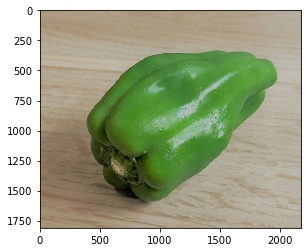

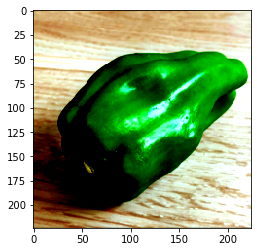

In [6]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
input_batch = torch.cat([input_tensor.unsqueeze(0)] * batch_size)

filtered_image = input_tensor.clone()
filtered_image = filtered_image.numpy().transpose((1, 2, 0))
filtered_image = np.float32(filtered_image)
filtered_image = np.clip(filtered_image, 0, 1)
plt.imshow(filtered_image)
plt.show()

Download the Torchvision AlexNet pre-traind model.

In [7]:
import torch
from torchvision import models
net = models.alexnet(pretrained=True).to('cuda').eval()
# net = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to('cuda').eval()
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Functions to get becchmark

In [8]:
import time
import functools

def processing_time(num_times, warmups=0):
    def _processing_time(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            for i in range(warmups):
                ret = func(*args, **kwargs)
            t0 = time.time()
            for i in range(num_times):
                ret = func(*args, **kwargs)
            t1 = time.time()
            print('Average a {0} times trial: {1:,f}sec/batch'.format(num_times, (t1 - t0) / num_times))
            return ret
        return wrapper
    return _processing_time

In [9]:
@processing_time(100, 10)
def test_inference(network, in_dat):
    with torch.no_grad():
        out_dat = network(in_dat)
    out_dat = out_dat.cpu()
    out_dat = out_dat.detach().numpy()
    return out_dat

## TrochScript traced model

In [10]:
traced_model = torch.jit.trace(net, torch.empty([batch_size, 3, 224, 224]).to("cuda"))
traced_model

AlexNet(
  original_name=AlexNet
  (features): Sequential(
    original_name=Sequential
    (0): Conv2d(original_name=Conv2d)
    (1): ReLU(original_name=ReLU)
    (2): MaxPool2d(original_name=MaxPool2d)
    (3): Conv2d(original_name=Conv2d)
    (4): ReLU(original_name=ReLU)
    (5): MaxPool2d(original_name=MaxPool2d)
    (6): Conv2d(original_name=Conv2d)
    (7): ReLU(original_name=ReLU)
    (8): Conv2d(original_name=Conv2d)
    (9): ReLU(original_name=ReLU)
    (10): Conv2d(original_name=Conv2d)
    (11): ReLU(original_name=ReLU)
    (12): MaxPool2d(original_name=MaxPool2d)
  )
  (avgpool): AdaptiveAvgPool2d(original_name=AdaptiveAvgPool2d)
  (classifier): Sequential(
    original_name=Sequential
    (0): Dropout(original_name=Dropout)
    (1): Linear(original_name=Linear)
    (2): ReLU(original_name=ReLU)
    (3): Dropout(original_name=Dropout)
    (4): Linear(original_name=Linear)
    (5): ReLU(original_name=ReLU)
    (6): Linear(original_name=Linear)
  )
)

In [11]:
input_batch = input_batch.to('cuda')

with torch.no_grad():
    outputs = traced_model(input_batch)

outputs = outputs.cpu()
outputs = outputs.detach().numpy()
for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image1:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image2:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image3:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image4:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image5:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image6:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image7:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926


In [12]:
outputs = test_inference(traced_model, input_batch)

Average a 100 times trial: 0.019262sec/batch


### Compile (single precision)

In [13]:
import torch_tensorrt

trt_ts_module = torch_tensorrt.compile(traced_model, inputs=[torch_tensorrt.Input(
            min_shape=[batch_size, 3, 224, 224],
            opt_shape=[batch_size, 3, 224, 224],
            max_shape=[batch_size, 3, 224, 224],
            dtype=torch.float
            )])

input_data = torch.randn((batch_size, 3, 224, 224))
input_data = input_data.to("cuda")

# result = trt_ts_module(input_data)
torch.jit.save(trt_ts_module, "trt_ts_module.ts")

In [14]:
with torch.no_grad():
    outputs = trt_ts_module(input_batch)

outputs = outputs.cpu()
outputs = outputs.detach().numpy()

for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image1:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image2:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image3:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image4:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image5:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image6:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image7:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562


In [15]:
outputs = test_inference(trt_ts_module, input_batch)

Average a 100 times trial: 0.016571sec/batch


In [16]:
import gc

del trt_ts_module
del outputs
del input_data

gc.collect()

5273

### Compile (half precision)

In [17]:
import torch_tensorrt

trt_ts_module = torch_tensorrt.compile(traced_model, inputs=[torch_tensorrt.Input(
            min_shape=[batch_size, 3, 224, 224],
            opt_shape=[batch_size, 3, 224, 224],
            max_shape=[batch_size, 3, 224, 224],
            dtype=torch.half
            )], 
            enabled_precisions = {torch.half})

input_data = torch.randn((batch_size, 3, 224, 224))
input_data = input_data.half().to("cuda")

input_data = input_data.half()
result = trt_ts_module(input_data)
torch.jit.save(trt_ts_module, "trt_ts_module_half.ts")

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


In [18]:
with torch.no_grad():
    outputs = trt_ts_module(input_batch.half())

outputs = outputs.cpu()
outputs = outputs.detach().numpy()

for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image1:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image2:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image3:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image4:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image5:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image6:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125
image7:
	bell_pepper:	15.875
	cucumber:	13.7578125
	Granny_Smith:	12.0078125


In [19]:
outputs = test_inference(trt_ts_module, input_batch.half())

Average a 100 times trial: 0.006560sec/batch


In [20]:
del trt_ts_module
del traced_model
del outputs
del input_data

gc.collect()

0

## TorchScript script model

In [21]:
script_model = torch.jit.script(net)
script_model

RecursiveScriptModule(
  original_name=AlexNet
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Conv2d)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Dropout)
  

In [22]:
with torch.no_grad():
    outputs = script_model(input_batch)

outputs = outputs.cpu()
outputs = outputs.detach().numpy()

for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image1:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image2:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image3:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image4:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image5:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image6:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926
image7:
	bell_pepper:	15.869314193725586
	cucumber:	13.746050834655762
	Granny_Smith:	12.042935371398926


In [23]:
outputs = test_inference(script_model, input_batch)

Average a 100 times trial: 0.018503sec/batch


### Compile (single precision)

In [24]:
trt_script_module = torch_tensorrt.compile(script_model, inputs=[torch_tensorrt.Input(
            min_shape=[batch_size, 3, 224, 224],
            opt_shape=[batch_size, 3, 224, 224],
            max_shape=[batch_size, 3, 224, 224],
            dtype=torch.float
            )])

input_data = torch.randn((batch_size, 3, 224, 224))
input_data = input_data.to("cuda")

# result = trt_script_module(input_data)
torch.jit.save(trt_script_module, "trt_script_module.ts")

In [25]:
with torch.no_grad():
    outputs = trt_script_module(input_batch)

outputs = outputs.cpu()
outputs = outputs.detach().numpy()

for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image1:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image2:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image3:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image4:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image5:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image6:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562
image7:
	bell_pepper:	15.869131088256836
	cucumber:	13.745674133300781
	Granny_Smith:	12.043106079101562


In [26]:
outputs = test_inference(trt_script_module, input_batch)

Average a 100 times trial: 0.016653sec/batch


In [27]:
del trt_script_module
del outputs
del input_data

gc.collect()

320

### Compile (half precision)

In [28]:
trt_script_module = torch_tensorrt.compile(script_model, inputs=[torch_tensorrt.Input(
            min_shape=[batch_size, 3, 224, 224],
            opt_shape=[batch_size, 3, 224, 224],
            max_shape=[batch_size, 3, 224, 224],
            dtype=torch.half
            )], 
            enabled_precisions = {torch.half})

input_data = torch.randn((batch_size, 3, 224, 224))
input_data = input_data.half().to("cuda")

input_data = input_data.half()
# result = trt_script_module(input_data)
torch.jit.save(trt_script_module, "trt_script_module_half.ts")

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


In [29]:
with torch.no_grad():
    outputs = trt_script_module(input_batch.half())

outputs = outputs.cpu()
outputs = outputs.detach().numpy()

for b in range(batch_size):
    print('image{}:'.format(b))
    idxlist = np.argsort(outputs[b])[:-4:-1]
    for i in idxlist:
        print('\t{}:\t{}'.format(class_dict[str(i)][1], outputs[b][i]))

image0:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image1:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image2:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image3:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image4:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image5:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image6:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125
image7:
	bell_pepper:	15.890625
	cucumber:	13.7734375
	Granny_Smith:	12.0078125


In [30]:
outputs = test_inference(trt_script_module, input_batch.half())

Average a 100 times trial: 0.006748sec/batch


In [31]:
del trt_script_module
del script_model
del outputs
del input_data

gc.collect()

0